<a href="https://colab.research.google.com/github/stephenbeckr/time-series-class/blob/main/Demos/TimeSeries_ARIMApredictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
install.packages("tseries")
library(tseries) # for Dickey-Fuller test

# Prediction with ARIMA models

Stephen Becker, 2022. Modified from demo of Will Kleiber 2018

## Synthetic data
Simulate ARIMA(1,1,0) and fit an AR(2), forecast under both models

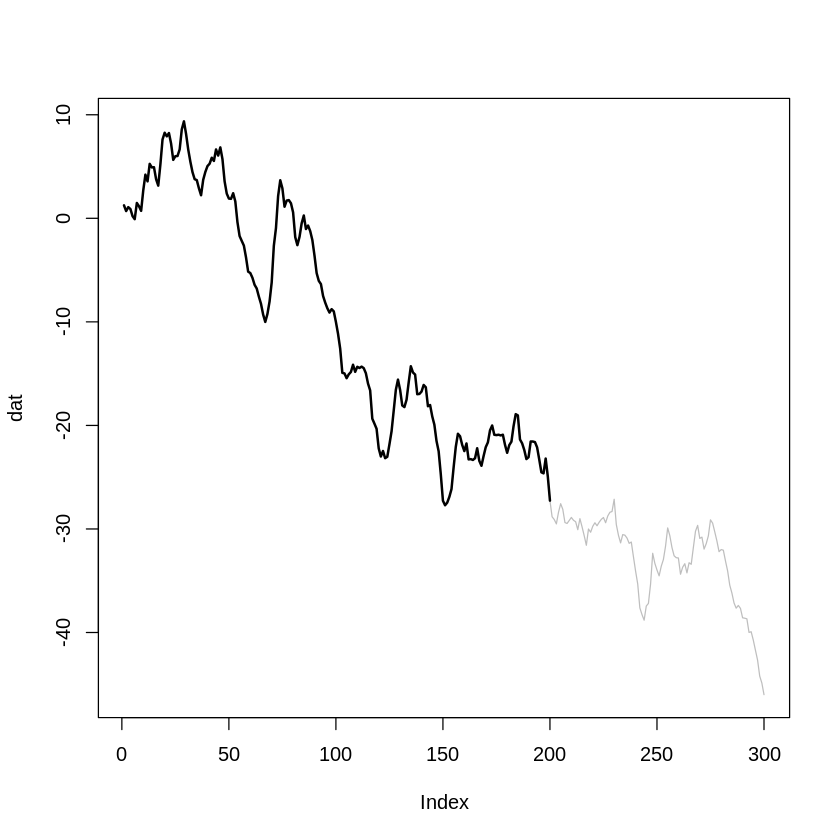

In [11]:
set.seed(6)
dat <- arima.sim(n=300,list(order=c(1,1,0),ar=0.5))
dat <- dat[-1]
obs <- dat[1:200]
out <- 201:length(dat)  # this is the hold-out data we'll use to see how well we do
plot(dat,col="grey",type="l")
lines(obs,lwd=2)

In [13]:
# Dickey-Fuller test
tseries::adf.test(dat)
tseries::adf.test(dat, k=0) # classic Dickey-Fuller


	Augmented Dickey-Fuller Test

data:  dat
Dickey-Fuller = -3.4698, Lag order = 6, p-value = 0.04598
alternative hypothesis: stationary



	Augmented Dickey-Fuller Test

data:  dat
Dickey-Fuller = -2.2559, Lag order = 0, p-value = 0.4684
alternative hypothesis: stationary


Recall that for a classic Dickey-Fuller test, the 0.01 quantile is -3.43, the 0.05 quantile is -2.86 and the 0.1 quantile is -2.57.  Anything below these and we can reject the null hypothesis at the corresponding confidence level.  Recall the null hypothesis is that we have a unit root (what the `adf.test` documentation calls "explosive").  Having a very low test statistic lets us be fairly confident there is no unit root... but what we really want to do is test if there is a unit root.

Let's repeat this with the difference data (which is from an ARMA model, no unit root). Do we detect this?

In [14]:
tseries::adf.test(diff(dat),k=0) # we should be very confident this does NOT have a unit root, so reject null

Warning message in tseries::adf.test(diff(dat), k = 0):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  diff(dat)
Dickey-Fuller = -10.998, Lag order = 0, p-value = 0.01
alternative hypothesis: stationary


Moving on to some model fitting and then prediction:

In [2]:
fit.ar2 <- arima(x=obs,order=c(2,0,0)) # includes intercept estimate
fit.arima110 <- arima(x=obs,order=c(1,1,0))

## Predict 50 steps ahead
pred.ar2 <- predict(fit.ar2, n.ahead=length(out), se.fit=TRUE)
pred.arima110 <- predict(fit.arima110, n.ahead=length(out), se.fit=TRUE)

names(pred.ar2)

Warning message in arima(x = obs, order = c(2, 0, 0)):
“possible convergence problem: optim gave code = 1”


[1] "pred" "se"

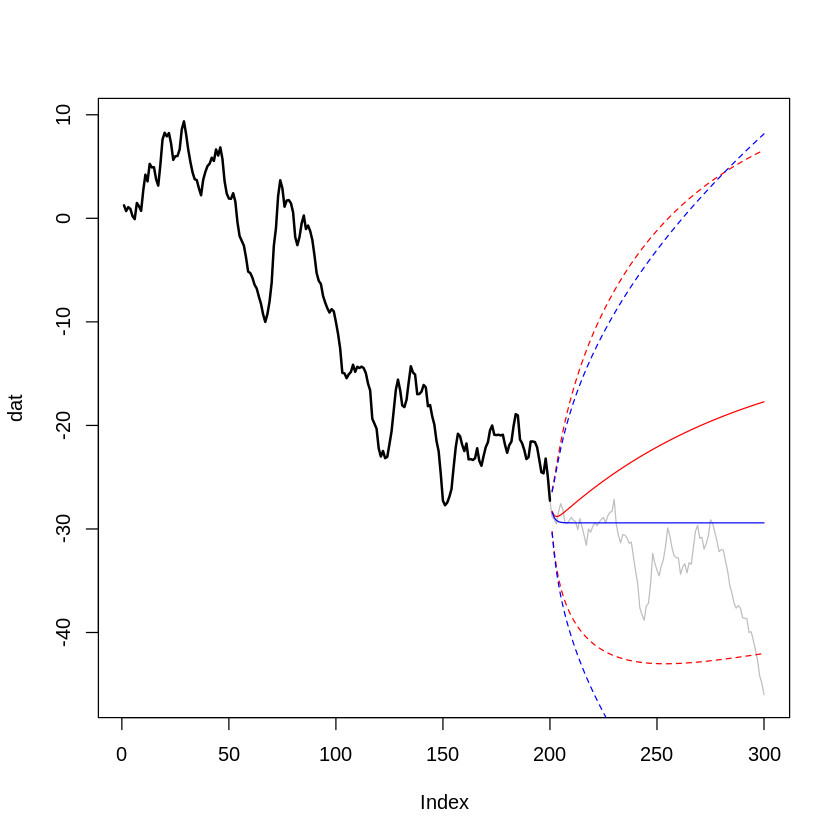

In [3]:
plot(dat,col="grey",type="l")
lines(obs,lwd=2)

# AR model
lines(pred.ar2$pred~out,col="red")
lines(c(pred.ar2$pred-2*pred.ar2$se)~out,col="red",lty=2)
lines(c(pred.ar2$pred+2*pred.ar2$se)~out,col="red",lty=2)

# ARIMA model
lines(pred.arima110$pred~out,col="blue")
lines(c(pred.arima110$pred-2*pred.arima110$se)~out,col="blue",lty=2)
lines(c(pred.arima110$pred+2*pred.arima110$se)~out,col="blue",lty=2)

Since we know the future, we can see which method does better in terms of root mean-squared error

In [4]:
sqrt(mean( (dat[out] - pred.ar2$pred)^2 ))
sqrt(mean( (dat[out] - pred.arima110$pred)^2 ))

[1] 12.35994

[1] 5.339633

Unsurprisingly, since this was a true ARIMA(1,1,0) process, the ARIMA fit does better than the AR(2) fit

## Google stock closing price data
Same as in the previous ARIMA demo

We'll see this data likely is ARIMA, although if we log transform it first (usually a good idea for stock data), then it's less clear that it's ARIMA

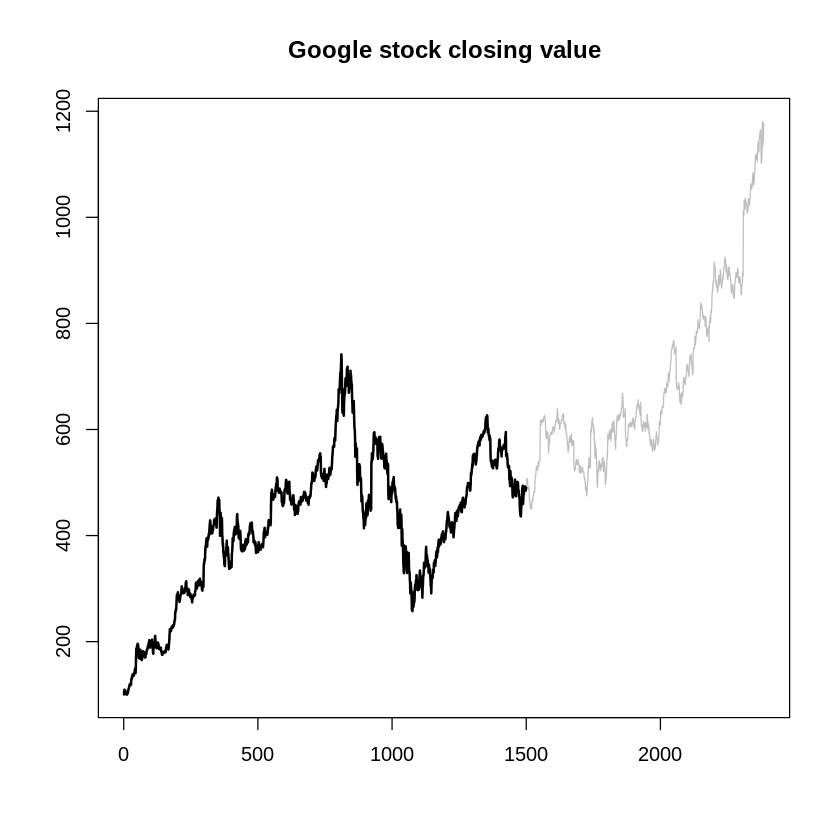

In [20]:
link <- url('https://github.com/stephenbeckr/time-series-class/raw/main/Data/GOOG20042014.csv')
dat <- read.csv(link)
dat <- rev(dat[,5])
# dat <- log(dat) # not a bad idea

obs <- dat[1:1500]  # observations
out <- 1501:length(dat) # hold-out data

plot(dat,type="l",xlab="",ylab="",main="Google stock closing value",col="grey")
lines(obs,lwd=2)

In [23]:
# augmented Dickey-Fuller test for stationarity
# (test for the null that x has a unit root, i.e., ARIMA)
tseries::adf.test(dat,k=0)

tseries::adf.test(diff(dat),k=0)


	Augmented Dickey-Fuller Test

data:  dat
Dickey-Fuller = -1.1294, Lag order = 0, p-value = 0.9179
alternative hypothesis: stationary


Warning message in tseries::adf.test(diff(dat), k = 0):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  diff(dat)
Dickey-Fuller = -49.365, Lag order = 0, p-value = 0.01
alternative hypothesis: stationary


What do we conclude? From the first test, we cannot reject the null hypothesis (which is that there is a unit root), so an ARIMA model is a good idea.

From the second test, the difference data is unlikely to have a unit root, i.e., it does not come from an ARIMA model

From all of this, we might suspect the data comes from an ARIMA model with $d=1$ (but not $d\ge 2$)

#### Fit the model and predict 50 steps ahead

In [24]:
fit.ar2 <- arima(x=obs,order=c(2,0,0)) # includes intercept estimate
fit.arima110 <- arima(x=obs,order=c(1,1,0))
fit.arima111 <- arima(x=obs,order=c(1,1,1))
fit.arima011 <- arima(x=obs,order=c(0,1,1))

# Predict
pred.ar2 <- predict(fit.ar2, n.ahead=length(out), se.fit=TRUE)
pred.arima110 <- predict(fit.arima110, n.ahead=length(out), se.fit=TRUE)
pred.arima111 <- predict(fit.arima111, n.ahead=length(out), se.fit=TRUE)
pred.arima011 <- predict(fit.arima011, n.ahead=length(out), se.fit=TRUE)

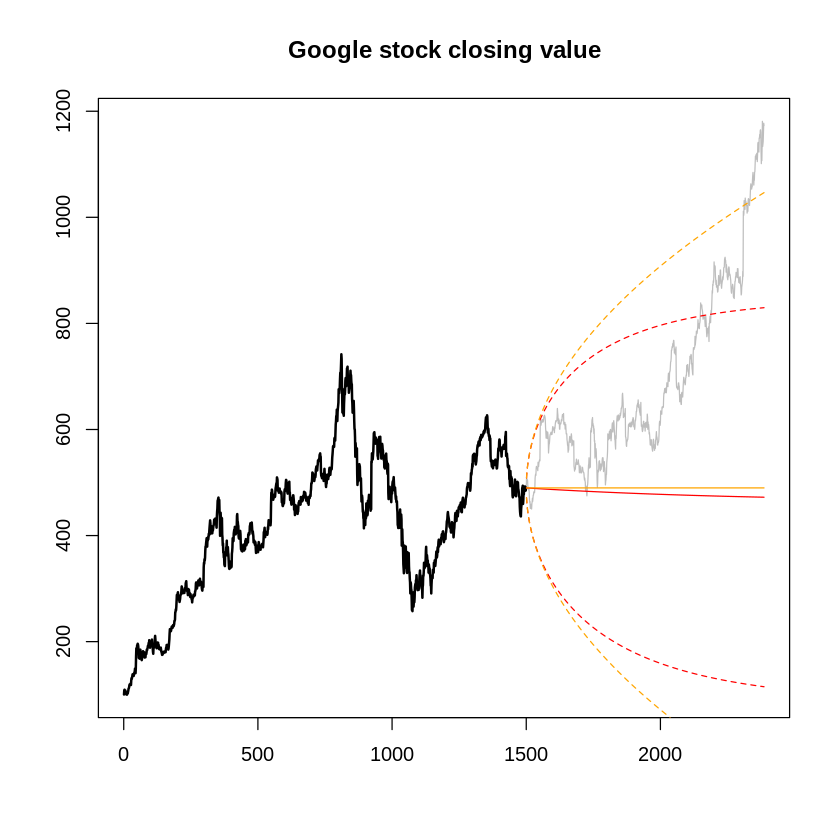

In [31]:
plot(dat,type="l",xlab="",ylab="",main="Google stock closing value",col="grey")
lines(obs,lwd=2)

lines(pred.ar2$pred~out,col="red")
lines(c(pred.ar2$pred-2*pred.ar2$se)~out,col="red",lty=2)
lines(c(pred.ar2$pred+2*pred.ar2$se)~out,col="red",lty=2)

lines(pred.arima110$pred~out,col="orange")
lines(c(pred.arima110$pred-2*pred.arima110$se)~out,col="orange",lty=2)
lines(c(pred.arima110$pred+2*pred.arima110$se)~out,col="orange",lty=2)

#   The ARIMA(1,1,1) and ARIMA(0,1,1) are very nearly the same as
#   the ARIMA(1,1,0) so I won't plot them
# lines(pred.arima111$pred~out,col="purple")
# lines(c(pred.arima111$pred-2*pred.arima110$se)~out,col="purple",lty=2)
# lines(c(pred.arima111$pred+2*pred.arima110$se)~out,col="purple",lty=2)

# lines(pred.arima011$pred~out,col="blue")
# lines(c(pred.arima011$pred-2*pred.arima110$se)~out,col="blue",lty=2)
# lines(c(pred.arima011$pred+2*pred.arima110$se)~out,col="blue",lty=2)

And let's see how well we actually did

In [32]:
## Root-mean prediction squared errors
sqrt(mean( (dat[out] - pred.ar2$pred)^2 ))
sqrt(mean( (dat[out] - pred.arima110$pred)^2 ))
sqrt(mean( (dat[out] - pred.arima111$pred)^2 ))
sqrt(mean( (dat[out] - pred.arima011$pred)^2 ))

[1] 275.9675

[1] 265.3597

[1] 265.3597

[1] 265.3597

All ARIMA models do about the same, and are better than the AR model

An interesting experiment would be to fit the log transformed data and see if that gives better predictions (make sure to undo the log transform at the end when evaluating RMSE so that it's an apples-to-apples comparison)